## Using Size loss with Cardiac Images

For this phase of the tutorial, we are going to apply the Size loss function to a real-world medical image segmentation problem. In particular, the Automatic Cardiac Diagnosis Challenge (ACDC) from MICCAI 2017. To download the dataset, please visit the website:
https://www.creatis.insa-lyon.fr/Challenge/acdc/databasesTraining.html. Follow the instructions to download the zip folder containing the ACDC data. Make sure to change the name of the file to **acdc.zip** and drag it to the **data** folder. In the terminal, run the following commands to create the dataset:

<code> sudo apt-get install unzip <code>
<code> make -B data/ACDC <code>

At the end, you will se a folder named "ACDC" available next to the toy dataset folder.

**Libraries**

In [2]:
import argparse
from pathlib import Path
from typing import Any, Tuple
from operator import itemgetter
import torch
import numpy as np
import torch.nn.functional as F
from torch import nn, einsum
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

**Utilities**

In [3]:
from utils.dataset import (SliceDataset)
from utils.residual_unet import ResidualUNet
from utils.losses import (CrossEntropy,
                          PartialCrossEntropy,
                          NaiveSizeLoss)
from utils.utils import (weights_init,
                         saveImages,
                         class2one_hot,
                         probs2one_hot,
                         one_hot,
                         tqdm_,
                         dice_coef)

**Configuring GPU**

If there is an available GPU, it is going to be contained in the variable 'device', otherwise it is going to be simply the GPU.

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 

# ACDC Dataset

In this more advanced example, we directly apply the concept of Size loss to the segmentation of cardiac MRI images. As before, our first task is to load the data in order to analize it.

In [5]:
root_dir = 'data/ACDC/'
dataset = 'ACDC'
K = 4 #Number of classe

'''Specifying the transforms for the data during training'''
transform = transforms.Compose([
                lambda img: img.convert('L'),
                lambda img: np.array(img)[np.newaxis, ...],
                lambda nd: nd /255,
                lambda nd: torch.tensor(nd, dtype=torch.float32)])

mask_transform = transforms.Compose([
        lambda img: np.array(img)[...],
        lambda nd: nd / (255 / (K - 1)),  
        lambda nd: torch.tensor(nd, dtype=torch.int64)[None, ...], 
        lambda t: class2one_hot(t, K=K),
        itemgetter(0)
    ])

In [6]:
batch_size = 1
'''Creating dataset objects to handle all our data samples'''
train_set = SliceDataset('train', root_dir, transform=transform, mask_transform=mask_transform, augment=True, equalize=False)
val_set = SliceDataset('val', root_dir, transform=transform, mask_transform=mask_transform, equalize=False)

'''Creating dataloaders, which help us iterate over the data samples'''
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, num_workers=4, shuffle=False)

>> Created train dataset with 1298 images...
>> Created val dataset with 206 images...


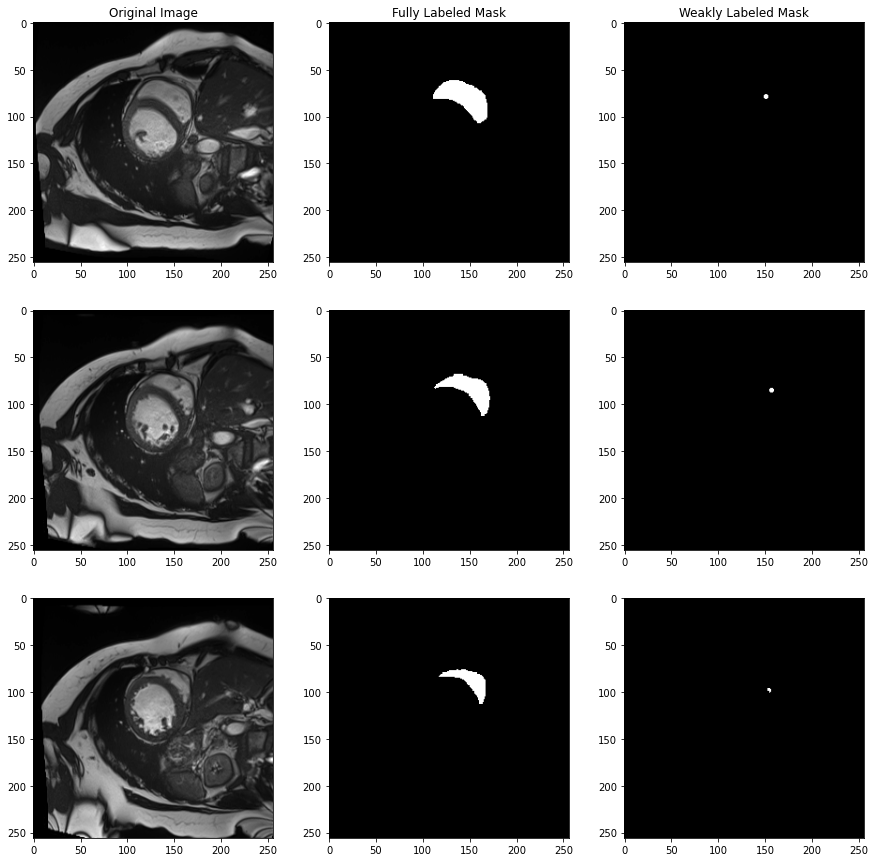

In [7]:
'''Displaying some examples'''
fig, axs = plt.subplots(3, 3)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(3):
    data = val_set[i+1]
    img = data['img'][0] #Image
    full_mask = data['full_mask'] #Fully annotated segmentation mask
    weak_mask = data['weak_mask'] #Weakly annotated segmentation mask
    axs[i,0].imshow(img.squeeze(), cmap='gray')
    axs[i,1].imshow(full_mask[1], cmap='gray')
    axs[i,2].imshow(weak_mask[1], cmap='gray')
axs[0,0].set_title('Original Image')
axs[0,1].set_title('Fully Labeled Mask')
axs[0,2].set_title('Weakly Labeled Mask')
plt.show()

**Creating a deeper CNN**

For this example, we require a more powerful architecture. We utilize a Residual U-Net to segment the images. Please refer to the file called **residual_unet.py** inside the **utils** folder.

In [ ]:
net = ResidualUNet(1, K)
net.init_weights()
net.to(device)

Initialized ResidualUNet succesfully


ResidualUNet(
  (down_1): Conv_residual_conv(
    (conv_1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv_2): Sequential(
      (0): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_runnin

**Creating loss functions**

PyTorch have several pre-defined loss functions that we can directly use. However, there might be times when we need our own loss function, e.g. size loss. Here we show how we can create any loss function from scratch. If we construct all our objects (inputs, networks, targets, etc.) as PyTorch tensors, creating and using a loss function during backpropagation is easier. To better understand how to create customize losses, please refer to the file called "losses.py".

In [10]:
ce_loss = CrossEntropy(idk=list(range(K))) #To supervise both background and foreground
partial_ce = CrossEntropy(idk=list(range(1, K))) #Avoid supervising background
sizeloss = NaiveSizeLoss(idk=list(range(1,K)))

Initialized CrossEntropy with {'idk': [0, 1, 2, 3]}
Initialized CrossEntropy with {'idk': [1, 2, 3]}
Initialized NaiveSizeLoss with {'idk': [1, 2, 3]}


**Setting training configuration**

In [11]:
epochs = 21 #Number of epochs to train
lr = 0.0005 #Learning rate
optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999)) #Optimizer
mode = 'full'
mode = 'unconstrained'
mode = 'constrained'

**Training phase**

In [12]:
losses = []
for i in range(epochs):
    net.train()
    
    log_ce = torch.zeros((len(train_loader)), device=device)
    log_sizeloss = torch.zeros((len(train_loader)), device=device)
    log_sizediff = torch.zeros((len(train_loader)), device=device)
    log_dice = torch.zeros((len(train_loader)), device=device)
    
    desc = f">> Training   ({i: 4d})"
    tq_iter = tqdm_(enumerate(train_loader), total=len(train_loader), desc=desc)
    for j, data in tq_iter:
        img = data["img"].to(device)
        full_mask = data["full_mask"].to(device)
        weak_mask = data["weak_mask"].to(device)

        bounds = data["bounds"].to(device)

        optimizer.zero_grad()
        
        # Sanity tests to see we loaded and encoded the data correctly
        assert 0 <= img.min() and img.max() <= 1
        B, _, W, H = img.shape
        assert B == 1  # Since we log the values in a simple way, doesn't handle more
        assert weak_mask.shape == (B, K, W, H)
        assert one_hot(weak_mask), one_hot(weak_mask)
        
        
        logits = net(img)
        pred_softmax = F.softmax(5 * logits, dim=1)
        pred_seg = probs2one_hot(pred_softmax)
        
        # `1:` for class 1 onward. This way handle both binary and mult-class
        # 1st item, all classes except background
        pred_size = einsum("bkwh->bk", pred_seg)[0, 1:].cpu()
        log_sizediff[j] = (pred_size - data["true_size"][0, 1:]).mean()  # do the class average for simplicity
        log_dice[j] = dice_coef(pred_seg, full_mask)[0, 1:].mean()
        
        if mode == 'full':
            ce_val = ce_loss(pred_softmax, full_mask)
            log_ce[j] = ce_val.item()

            log_sizeloss[j] = 0
        
            lossEpoch = ce_val
            
        elif mode == 'unconstrained':
            ce_val = partial_ce(pred_softmax, weak_mask)
            log_ce[j] = ce_val.item()

            log_sizeloss[j] = 0

            lossEpoch = ce_val 
        elif mode == 'constrained':
            ce_val = partial_ce(pred_softmax, weak_mask)
            log_ce[j] = ce_val.item()

            sizeLoss_val = sizeloss(pred_softmax, bounds)
            log_sizeloss[j] = sizeLoss_val[0, 1:].mean()

            lossEpoch = ce_val + sizeLoss_val.sum() / 100
        
        #Backward pass
        lossEpoch.backward()
        optimizer.step()
        
        tq_iter.set_postfix({"DSC": f"{log_dice[:j+1].mean():05.3f}",
                                 "SizeDiff": f"{log_sizediff[:j+1].mean():07.1f}",
                                 "LossCE": f"{log_ce[:j+1].mean():5.2e}",
                                 **({"LossSize": f"{log_sizeloss[:j+1].mean():5.2e}"} if mode == 'constrained' else {})})
        tq_iter.update(1)
    tq_iter.close()
    
    losses.append(log_ce.mean().cpu().item())
    
    if (i % 5) == 0:
        saveImages(net, val_loader, 1, i, dataset, mode, device)

>> Validation (  20): 100%|██████████████████████████████████████████████████████████████████| 206/206 [14.19it/s, DSC=0.531]


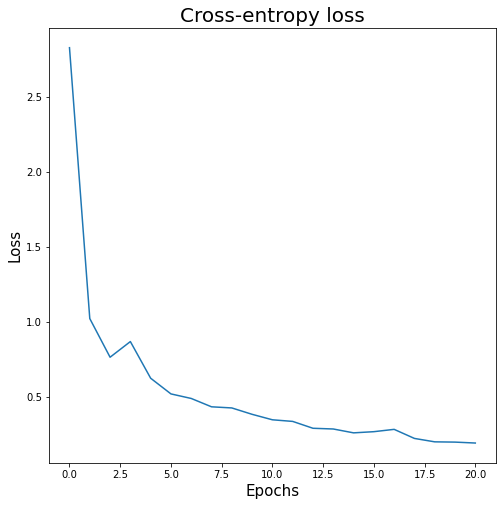

In [13]:
'Plotting cross-entropy loss'''
fig = plt.figure(0)
fig.set_figheight(8)
fig.set_figwidth(8)

plt.plot(np.arange(epochs), losses)

plt.title('Cross-entropy loss', fontsize=20)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.show()